In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import tensorflow_decision_forests as tfdf

# Predicting energy consumption of a house in Canada using weather data

This project aims to show a process of exploring different approaches to
building an energy predictor for a specific house in Canada.
The project shows a process of exploratory data analysis (EDA) and consequent attempts
of building predictors. The decisions for predictor types and approaches are based on the
findings about the data during the EDA.

This document is structured as a story and a consequent log of our reasoning
and code implementation that followed it.

---

The dataset used, which is called The Almanac of Minutely Power dataset (AMPds), is extensively discussed in the attached paper.

Initially available data was of 2 categories:

<!-- width="500" -->
<img src="./images/diag.png" alt="day"/>  

- **Energy data:**

    Energy from one house in Canada, sampled every minute.
    for 2 years, in the period from April 2012 until March 2014
    Figure above shows the energy appliances that each was recorded for the given period, and their relation.
    
    The "Whole House" power meter is an aggregate of all individual appliances, which all have their own meters and associated data tables. Apart from that, there is a fraction of energy recording that is "unmetered" - orange in the figure. This all the other appliances in the house that did not have dedicated meters attached.
    
    Their separate contribution can be derived as the difference of the whole house and all the metered appliances, and as shown in the report will be treated as a separate appliance.
    Each meter has 730 days of captured data.

    According to the ground plan in the figure below, the garage is a separate building, but it is still a part of the "whole house" energy table according to the first figure. Therefore we will consider it as part of the prediction for the whole house during the evaluation.

<img src="./images/plan.png" alt="day" width="400"/>  
    pl
- **Weather data:**

    Hourly weather data was downloaded from the Environment Canadas Weather Office which has a weather station at YVR (Vancouver International Airport) located at latitude of 49.20, longitude of −123.18, and elevation of 4.30 m. The test house is approximately 18 km from YVR with an elevation difference of approximately 75 m.

--- 

Our initial assumption was that one can predict energy consumption of a house
on a given day given weather information like average temperature on that day,
humidity, and also seasonal information like month.

It is also assumed that the energy consumption follows different patterns during
daytime and nighttime, due to the natural rhythm of humans who tend to sleep at night
and therefore not use various appliances in the house.

Average temperature during the night is also always lower than that of the same day,
so night and day times are treated separately.

---

As a general outline we look at 2 approaches of applying the regression predictors:

- Fitting a model for predicting the aggregate "Whole house" energy, given average temperature
and other weather data as input

- Fitting several models for every individual appliance, and deriving a total prediction for
hte house as the sum of these predictions, given the same type of inputs

The ultimate goal is to compare the accuracy of each approach and conclude which one is better and why.

Some of the text is inserted as Markdown blocks between the code, while some more
narrow-scoped explanations are in the code comments.

---

### Results

_The same section is written after the analysis for the nightly data completed, but placed here for convenience._
_Also, the figures for the curve fitting result of all the 22+22 models appeared to be too small when exported to pdf from Jupyter, so they are attached to this report as separate files curves-day.png and curves-night.png_
#### __For Night data:__

As a result we get a Mean Absolute Error of **2257.57** for the standalone predictor, and **2545.11** for the aggregate of 21 individual models for house components on a night dataset.

Both of the errors show that the method does not work too well for the given data, perhaps more data preprocessing and cleaning could help make the predictors more accurate.

#### __For Day data:__
We repeat the same procedure for the day dataset below, which yields respective Mean Absolute Errors of **2538.42** and  **2772.87**.
The difference between two different aproaches for day data are in sync with the night approach, but a re both relatively higher, which means that the daily data is harder to describe with a regression model.

This is in line with the initial assumption that the energy consumption during the day is more dependant on the activities of inhabitants which are less related to weather.

In [2]:
# Import minutely energy data from separate appliance tables into separate dataframes
north_bedroom = pd.read_csv('archive/Electricity_B1E.csv')
south_bedroom = pd.read_csv('archive/Electricity_B2E.csv')
basement_pl = pd.read_csv('archive/Electricity_BME.csv')
clothes_dryer = pd.read_csv('archive/Electricity_CDE.csv')
clothes_washer = pd.read_csv('archive/Electricity_CWE.csv')
dinning_p = pd.read_csv('archive/Electricity_DNE.csv')
dishwasher = pd.read_csv('archive/Electricity_DWE.csv')
workbench = pd.read_csv('archive/Electricity_EBE.csv')
security = pd.read_csv('archive/Electricity_EQE.csv')
fridge = pd.read_csv('archive/Electricity_FGE.csv')
furnace = pd.read_csv('archive/Electricity_FRE.csv')
garage = pd.read_csv('archive/Electricity_GRE.csv')
heat_pump = pd.read_csv('archive/Electricity_HPE.csv')
hot_water = pd.read_csv('archive/Electricity_HTE.csv')
office = pd.read_csv('archive/Electricity_OFE.csv')
outside_p = pd.read_csv('archive/Electricity_OUE.csv')
tv = pd.read_csv('archive/Electricity_TVE.csv')
utility_room_p = pd.read_csv('archive/Electricity_UTE.csv')
oven = pd.read_csv('archive/Electricity_WOE.csv')
rental_suite = pd.read_csv('archive/Electricity_RSE.csv') 
whole_house = pd.read_csv('archive/Electricity_WHE.csv')

# Import hourly weather data
hourly_weather = pd.read_csv('archive/Climate_HourlyWeather.csv')

# Print columns of energy and weather data
print(whole_house.columns)
print(hourly_weather.columns)

Index(['unix_ts', 'V', 'I', 'f', 'DPF', 'APF', 'P', 'Pt', 'Q', 'Qt', 'S',
       'St'],
      dtype='object')
Index(['Date/Time', 'Year', 'Month', 'Day', 'Time', 'Data Quality', 'Temp (C)',
       'Temp Flag', 'Dew Point Temp (C)', 'Dew Point Temp Flag', 'Rel Hum (%)',
       'Rel Hum Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather'],
      dtype='object')


**As a next step we go though all the energy data and aggregate it such that instead
of minutely readings every pair of rows represent a whole day, each of the rows being a daytime or nighttime period for the given day**

In [3]:
# Helper funciton - categorize time into day and night
def categorize_time(time_str):
    '''
    The hours 8 - 23 are chosen arbitrarily
    Possible improvement would be a better way to separate
    day and night, perhaps even based on the time of the year
    '''
    hour = int(str(time_str).split(':')[0])
    if hour >= 8 and hour <= 23:
        return 'day'
    else:
        return 'night'

# Helper function - get date, time, weekday and time of the day as separate columns
# from the 'unix_ts' column of energy data
def get_time(df, name):
    # Create separate columns for ease of aggregation
    df['date'] = pd.to_datetime(pd.to_datetime(df['unix_ts'], unit='s').dt.date)
    df['time'] = pd.to_datetime(df['unix_ts'], unit='s').dt.time
    df['weekday'] = pd.to_datetime(df['unix_ts'], unit='s').dt.dayofweek
    # Create a column for classifying date and night time
    df['Time_of_day'] = df['time'].apply(lambda x: categorize_time(x))
    # Select only potentially relevant columns: Power (P), Energy (Pt) and date/time information
    df = df[['P', 'Pt', 'date', 'time', 'weekday', 'Time_of_day']]
    # Group the minutes (every row is a minute) by times of day for every date,
    # so the resulting dataframe consists of pairs of rows that each represent a day
    Pt = df.groupby(['date', 'weekday', 'Time_of_day'])
    # Get energy consumed per half day, as delta between first and last reading
    # of the incremental energy column for the period in question
    p_max = Pt.max()['Pt']
    p_min = Pt.min()['Pt']
    d = p_max - p_min
    d = d.reset_index()
    # create a column that has the appliance name in it for joining in master DF later
    d[f'{name}_Pt'] = d['Pt']
    d = d.drop('Pt', axis=1)

    return d

dfs = [
    north_bedroom, south_bedroom, basement_pl, clothes_dryer, clothes_washer, dinning_p, dishwasher, workbench,
    security, fridge, furnace, garage, heat_pump, hot_water, office, outside_p, tv, utility_room_p, oven, rental_suite, whole_house
    ]

names = [
    'north_bedroom', 'south_bedroom', 'basement_pl', 'clothes_dryer', 'clothes_washer', 'dinning_p', 'dishwasher', 'workbench', 
    'security', 'fridge', 'furnace', 'garage', 'heat_pump', 'hot_water', 'office', 'outside_p', 'tv', 'utility_room_p', 'oven', 'rental_suite', 'whole_house'
    ]

# Apply helper function to all separate applaince tables to get them in the right format;
# now all separate dfs of all energy sources have date, weekday and Time_of_day
# and are aggregated
dfs = [get_time(df, name) for df, name in list(zip(dfs, names))]

In [4]:
# Show that every dataframe now is of the same aggregated format
print(dfs[0].head(2))
print(dfs[1].head(2))

        date  weekday Time_of_day  north_bedroom_Pt
0 2012-04-01        6         day                 5
1 2012-04-01        6       night                 1
        date  weekday Time_of_day  south_bedroom_Pt
0 2012-04-01        6         day               251
1 2012-04-01        6       night                 9


**Next we join all the appliances and the whole house in the same dataframe.**

Here we also calculate the "unmetered" part as a difference of the whole house and all the metered ones,
and put it in a separate column.

In [5]:
all_df = dfs[0].set_index(['date', 'Time_of_day'])

for df in dfs[1:]:
    all_df = all_df.join(df.set_index(['date', 'Time_of_day']).drop(['weekday'], axis=1))

# Join all the rooms and appliances in the same dataframe
all_df = all_df.reset_index()

# Calculate the unmetered energy consumption as a separate appliance to build a separate predictor
pt_cols = [col for col in all_df.columns if '_Pt' in col and col != 'whole_house_Pt']
all_df['unmetered_Pt'] = all_df['whole_house_Pt'] - all_df[pt_cols].sum(axis=1)

# Show the resulting columns of the dataframe
all_df.columns

Index(['date', 'Time_of_day', 'weekday', 'north_bedroom_Pt',
       'south_bedroom_Pt', 'basement_pl_Pt', 'clothes_dryer_Pt',
       'clothes_washer_Pt', 'dinning_p_Pt', 'dishwasher_Pt', 'workbench_Pt',
       'security_Pt', 'fridge_Pt', 'furnace_Pt', 'garage_Pt', 'heat_pump_Pt',
       'hot_water_Pt', 'office_Pt', 'outside_p_Pt', 'tv_Pt',
       'utility_room_p_Pt', 'oven_Pt', 'rental_suite_Pt', 'whole_house_Pt',
       'unmetered_Pt'],
      dtype='object')

Now we need to make sure that the weather data, that is initially in hourly samples, is aggregated on the same scale as the energy data now.

In [6]:
# Get Time_of_day for weather dataframe too, same helper function
hourly_weather['Time_of_day'] = hourly_weather['Time'].apply(lambda x: categorize_time(x))
hourly_weather.head(10)

# Group weather dataframe in the same way as the energy dataframe is grouped
daily_avg_hourly_weather = hourly_weather.groupby(['Year', 'Month', 'Day', 'Time_of_day']) \
                                         .mean(numeric_only=True)[['Temp (C)', 'Rel Hum (%)', 'Wind Spd (km/h)', 'Stn Press (kPa)', 'Hmdx']] \
                                         .reset_index()

# Make the date column from separate Yar, Month and Day present in the original weather df to be consistent with energy df
daily_avg_hourly_weather['date'] = (
    daily_avg_hourly_weather['Year'].astype(str) + '-' + daily_avg_hourly_weather['Month'].astype(str).str.zfill(2) + '-' +  daily_avg_hourly_weather['Day'].astype(str).str.zfill(2)
    )

# Drop day (as in day of the month)
daily_avg_hourly_weather = daily_avg_hourly_weather.drop(['Day'], axis=1)
# Show sample of weather data
daily_avg_hourly_weather.head(1)

,Year,Month,Time_of_day,Temp (C),Rel Hum (%),Wind Spd (km/h),Stn Press (kPa),Hmdx,date
0,2012,4,day,8.03125,64.75,12.4375,101.568125,NaN,2012-04-01


Finally, we join everything in a single dataframe

In [7]:
# Convert energy data column from datetime format to string, same as in weather df, for ease of joining
all_df['date'] = all_df['date'].astype(str)

# Join energy and weather dataframes by date and Time_of_day
master_df = all_df.set_index(['date', 'Time_of_day']) \
                  .join( \
                  daily_avg_hourly_weather.set_index(['date', 'Time_of_day']), \
                  how='left')

# Add a column that takes values 0 and 1 depending on whether the day is a weekend or not
master_df['weekend'] = (master_df['weekday'] > 4).astype(int)
master_df = master_df.reset_index()

# as a result we have a master dataframe with energy and weather with 1462 rows, 2 for very day of 2 years
print(len(master_df))

master_df.head(5)


1461


,date,Time_of_day,weekday,north_bedroom_Pt,south_bedroom_Pt,basement_pl_Pt,clothes_dryer_Pt,clothes_washer_Pt,dinning_p_Pt,dishwasher_Pt,...,whole_house_Pt,unmetered_Pt,Year,Month,Temp (C),Rel Hum (%),Wind Spd (km/h),Stn Press (kPa),Hmdx,weekend
0,2012-04-01,day,6,5,251,1297,0,225,17,0,...,21753,1754,2012.0,4.0,8.03125,64.7500,12.4375,101.568125,NaN,1
1,2012-04-01,night,6,1,9,387,0,0,25,0,...,1594,97,2012.0,4.0,3.63750,85.5000,28.6250,100.226250,NaN,1
2,2012-04-02,day,0,6,160,794,0,196,0,0,...,17741,1753,2012.0,4.0,10.88125,57.9375,23.8750,101.551875,NaN,0
3,2012-04-02,night,0,33,187,1565,2578,0,50,805,...,16053,2295,2012.0,4.0,7.36250,72.2500,22.8750,102.133750,NaN,0
4,2012-04-03,day,1,6,147,563,0,0,0,0,...,20172,2204,2012.0,4.0,6.10000,79.8125,16.1250,101.187500,NaN,0


Initially we wanted to remove the energy outliers in the 99th quantile of all the readings for every appliance,
but this resulted in too many rows removed (~300 out of 1400)

Later on we realized that the influence of these on the predictor are not necessarily bad, as usually these outliers happen in line with extreme weather changes.

**P.S.**
After plotting the relation of readings for some particular parts (whole house, fridge, unmetered and heat pump during the day) later in the report, some outliers prevent nice visualisation as they make the plot scale too large. We remove them here retroactively manually.

As an improvement, a better approach to remove outliers can be proposed.

Now we create two separate dataframes for day and night data for analysing them separately.
As mentioned before, patterns of both weather and energy consumption are dramatically different
during the day and at night.

We plot the temperature over all recording period for illustration of the point below.

In [8]:
# Get rows that represent daytime in a separate dataframe
master_day_df = master_df.loc[master_df['Time_of_day'] == 'day']
master_day_df.reset_index()

q = master_day_df["whole_house_Pt"].quantile(0.99)
master_day_df = master_day_df[master_day_df['whole_house_Pt'] < q]
q = master_day_df["fridge_Pt"].quantile(0.99)
master_day_df = master_day_df[master_day_df['fridge_Pt'] < q]
q = master_day_df["unmetered_Pt"].quantile(0.99)
master_day_df = master_day_df[master_day_df['unmetered_Pt'] < q]
q = master_day_df["heat_pump_Pt"].quantile(0.99)
master_day_df = master_day_df[master_day_df['heat_pump_Pt'] < q]

# Get rows that represent nighttime in a separate dataframe
master_night_df = master_df.loc[master_df['Time_of_day'] == 'night']
master_night_df.reset_index()
# Split sanity check
print(len(master_day_df)) # 698 days
print(len(master_night_df)) # 715 nights

698
731


/var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/ipykernel_92603/2865806422.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_t.show()


Text(0.0, 1.0, 'Day and Night')

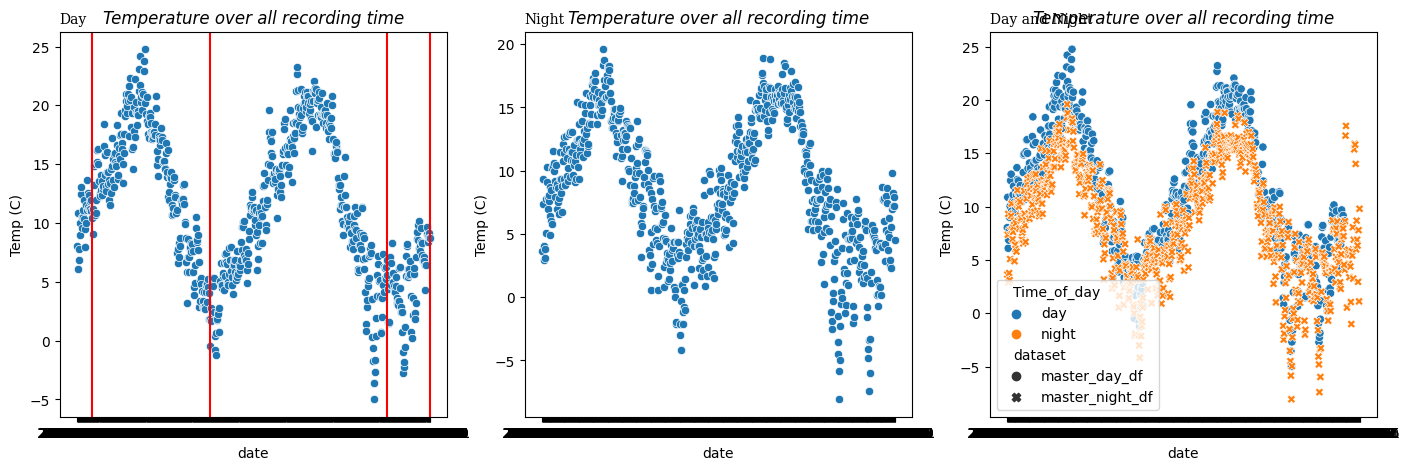

In [9]:
# I want to have a separate predictor for periods where the temperature patterns are different
fig_t, ax_t = plt.subplots(1, 3, figsize=(17, 5))

plot = sns.scatterplot(data=master_day_df, x="date", y="Temp (C)", ax=ax_t[0])
ax_t[0].set_title('Temperature over all recording time', fontstyle='italic')
ax_t[0].set_title("Day", fontfamily='serif', loc='left', fontsize='medium')
#  Draw vertical line with values

# First in the dataset
plot.axvline('2012-05-01', c='red')
plot.axvline('2013-01-01', c='red')
plot.axvline('2014-01-01', c='red')

# Last in the dataset
plot.axvline('2014-04-01', c='red')

# We can see that year 2012 is missing values between 01-01 and 04-01
# Year 2014 starts from 01-01 and ends at 04-01

# We need to select 
sns.scatterplot(data=master_night_df, x="date", y="Temp (C)", ax=ax_t[1])
ax_t[1].set_title('Temperature over all recording time', fontstyle='italic')
ax_t[1].set_title("Night", fontfamily='serif', loc='left', fontsize='medium')

fig_t.show()

concatenated = pd.concat([master_day_df.assign(dataset='master_day_df'), \
                          master_night_df.assign(dataset='master_night_df')])

sns.scatterplot(x='date', y='Temp (C)', data=concatenated, style='dataset', hue='Time_of_day', ax=ax_t[2])
ax_t[2].set_title('Temperature over all recording time', fontstyle='italic')
ax_t[2].set_title("Day and Night", fontfamily='serif', loc='left', fontsize='medium')
# plt.show()

In [ ]:
# We use the profiling library to analyse the dataframes automatically and get initial insights
profile_day = ProfileReport(master_day_df, title="Profiling Report Day")
profile_day.to_file('./daytime.html')

profile_night = ProfileReport(master_night_df, title="Profiling Report Night")
profile_night.to_file('./nighttime.html')

# profile_total = ProfileReport(master_df, title="Profiling Report Total")
# profile_total.to_file('./total.html')

After applying the profiling library, among a lot of other interesting insights, like distributions of every appliance energy, we take a look at correlation matrices for day and night data.

The full analysis reports for both can be reviewed in the attached `daytime.html` and `nighttime.html`.

<img src="./images/day_corr.png" alt="day" width="500"/>

<img src="./images/night_corr.png" alt="night" width="500"/>

It is evident that the following correlations of energy types to weather types need to be explored in more detail:

For daytime:
- Fridge and Temperature, positive correlation (intuitively the warmer it is, the harder the fridge works to keep the internal temp setpoint)
- North Bedroom and Temperature, negative correlation
- Heat Pump and Temperature, negative correlation (intuitively the warmer it is, the less heating needed)
- Unmetered and Temperature, negative correlation

For nighttime:
- All of the above mentioned correlations are stronger
- Other correlations with temperature are more distinctive

It can be explained with the fact that at night the behavioural factor of inhabitants is minimised.

In [11]:
# The reports also show that most of the Hmdx readings from weather data are missing
# Count the NaN values, print columns that have more than 10 NaNs
c = master_day_df.columns.to_numpy()
for _, i in enumerate(c):
    day_nan_count = master_day_df[i].isna().sum()
    if day_nan_count > 10:
        print(f'Day: {i} - {day_nan_count} / {len(master_day_df)} NaNs')

c = master_night_df.columns.to_numpy()
for _, i in enumerate(c):
    day_nan_count = master_night_df[i].isna().sum()
    if day_nan_count > 10:
        print(f'Night: {i} - {day_nan_count} / {len(master_night_df)} NaNs')

# So we can drop the Hmdx column form both DFs, and from the main DF
master_day_df = master_day_df.drop('Hmdx', axis=1)
master_night_df = master_night_df.drop('Hmdx', axis=1)
master_df = master_df.drop('Hmdx', axis=1)

Day: Hmdx - 604 / 698 NaNs
Night: Hmdx - 725 / 731 NaNs


We plot the most correlated pairs of energy / weather according to correlation matrix for a basic ides of what the relations look like.

/var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/ipykernel_92603/106619785.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/ipykernel_92603/106619785.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_1.show()
/var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/ipykernel_92603/106619785.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_2.show()
/var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/ipykernel_92603/106619785.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_3.show()


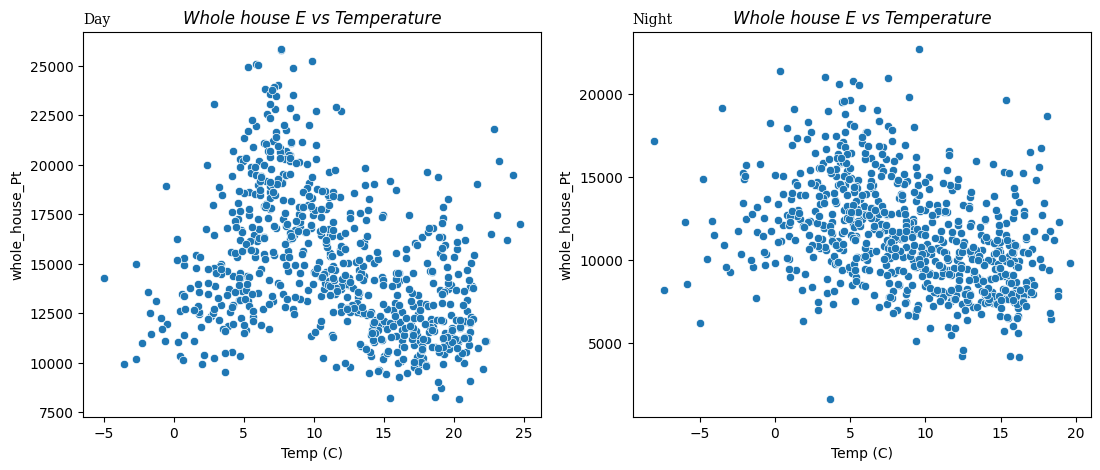

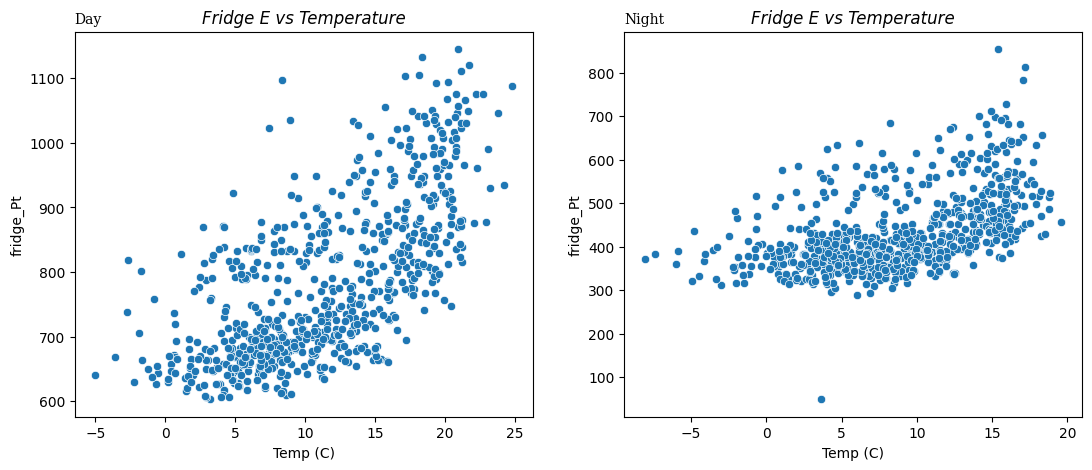

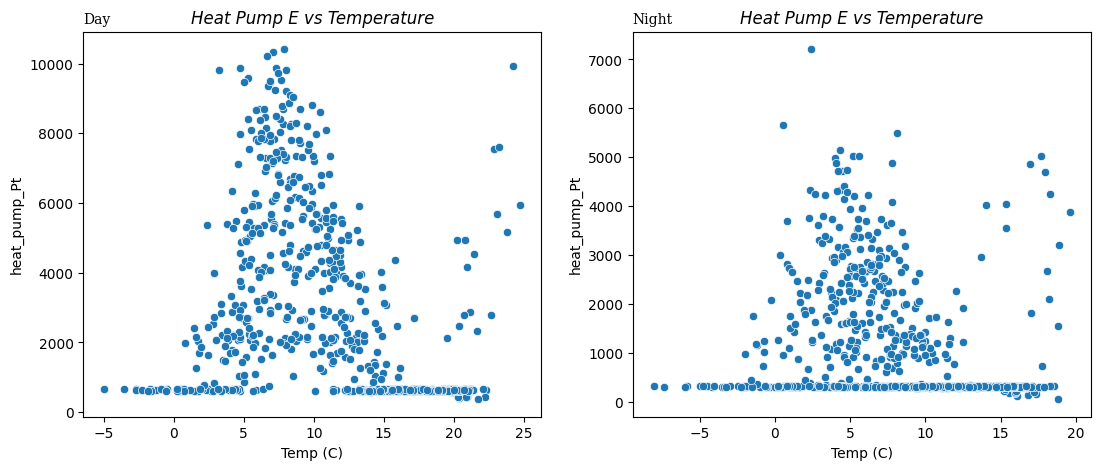

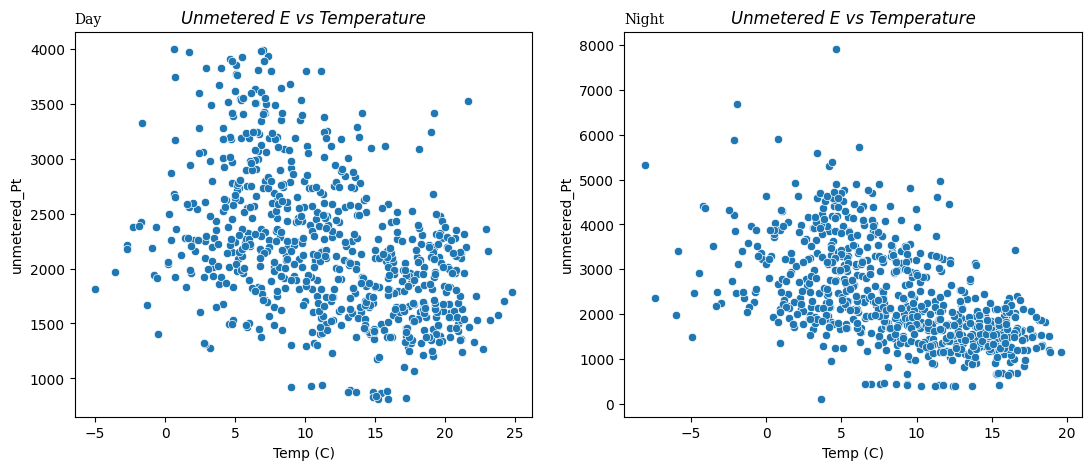

In [12]:
# ------------------ Plot whole house vs temp, both day and night
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

sns.scatterplot(data=master_day_df, x="Temp (C)", y="whole_house_Pt", ax=ax[0])
ax[0].set_title('Whole house E vs Temperature', fontstyle='italic')
ax[0].set_title("Day", fontfamily='serif', loc='left', fontsize='medium')

sns.scatterplot(data=master_night_df, x="Temp (C)", y="whole_house_Pt", ax=ax[1])
ax[1].set_title('Whole house E vs Temperature', fontstyle='italic')
ax[1].set_title("Night", fontfamily='serif', loc='left', fontsize='medium')

fig.show()

# ------------------ Plot fridge vs temp, both day and night
fig_1, ax_1 = plt.subplots(1, 2, figsize=(13, 5))

sns.scatterplot(data=master_day_df, x="Temp (C)", y="fridge_Pt", ax=ax_1[0])
ax_1[0].set_title('Fridge E vs Temperature', fontstyle='italic')
ax_1[0].set_title("Day", fontfamily='serif', loc='left', fontsize='medium')

sns.scatterplot(data=master_night_df, x="Temp (C)", y="fridge_Pt", ax=ax_1[1])
ax_1[1].set_title('Fridge E vs Temperature', fontstyle='italic')
ax_1[1].set_title("Night", fontfamily='serif', loc='left', fontsize='medium')

fig_1.show()

# ------------------ Plot heat pump vs temp, both day and night
fig_2, ax_2 = plt.subplots(1, 2, figsize=(13, 5))

sns.scatterplot(data=master_day_df, x="Temp (C)", y="heat_pump_Pt", ax=ax_2[0])
ax_2[0].set_title('Heat Pump E vs Temperature', fontstyle='italic')
ax_2[0].set_title("Day", fontfamily='serif', loc='left', fontsize='medium')

sns.scatterplot(data=master_night_df, x="Temp (C)", y="heat_pump_Pt", ax=ax_2[1])
ax_2[1].set_title('Heat Pump E vs Temperature', fontstyle='italic')
ax_2[1].set_title("Night", fontfamily='serif', loc='left', fontsize='medium')

fig_2.show()

# ------------------ Plot unmetered vs temp, both day and night
fig_3, ax_3 = plt.subplots(1, 2, figsize=(13, 5))

sns.scatterplot(data=master_day_df, x="Temp (C)", y="unmetered_Pt", ax=ax_3[0])
ax_3[0].set_title('Unmetered E vs Temperature', fontstyle='italic')
ax_3[0].set_title("Day", fontfamily='serif', loc='left', fontsize='medium')

sns.scatterplot(data=master_night_df, x="Temp (C)", y="unmetered_Pt", ax=ax_3[1])
ax_3[1].set_title('Unmetered E vs Temperature', fontstyle='italic')
ax_3[1].set_title("Night", fontfamily='serif', loc='left', fontsize='medium')

fig_3.show()


It can be seen that only fridge and unmetered nightly are somewhat linearly related to temperature, other relations are more complex.
_All_ the pairs of relations are visualed in the `.html` reports mentioned before and attached to this report.

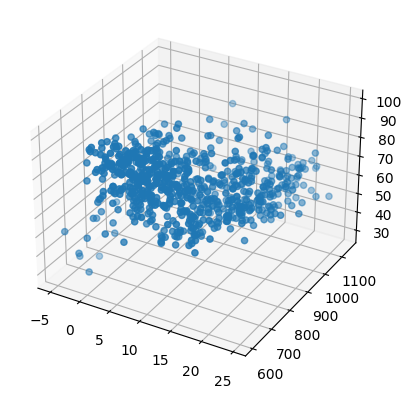

In [13]:
# We can also visualise multiple variables in 3D space, but could not find a reason in the given time
# Perhaps more interesting insights coould be discussed here
fig_3d = plt.figure()
ax_3d_1 = fig_3d.add_subplot(projection='3d')
ax_3d_1.scatter(master_day_df["Temp (C)"], master_day_df["fridge_Pt"], master_day_df["Rel Hum (%)"])

Now we start building the regression models as discussed in the initial approach.
We start with the most approachable - linear regression for the fridge versus temperature.

We later see if we can make improvements. We use tensorflow ML framework.

First we train only on night data as it is less noisy and more stable, as was  seen beofre the analysis reports for daytime a nd nighttime

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


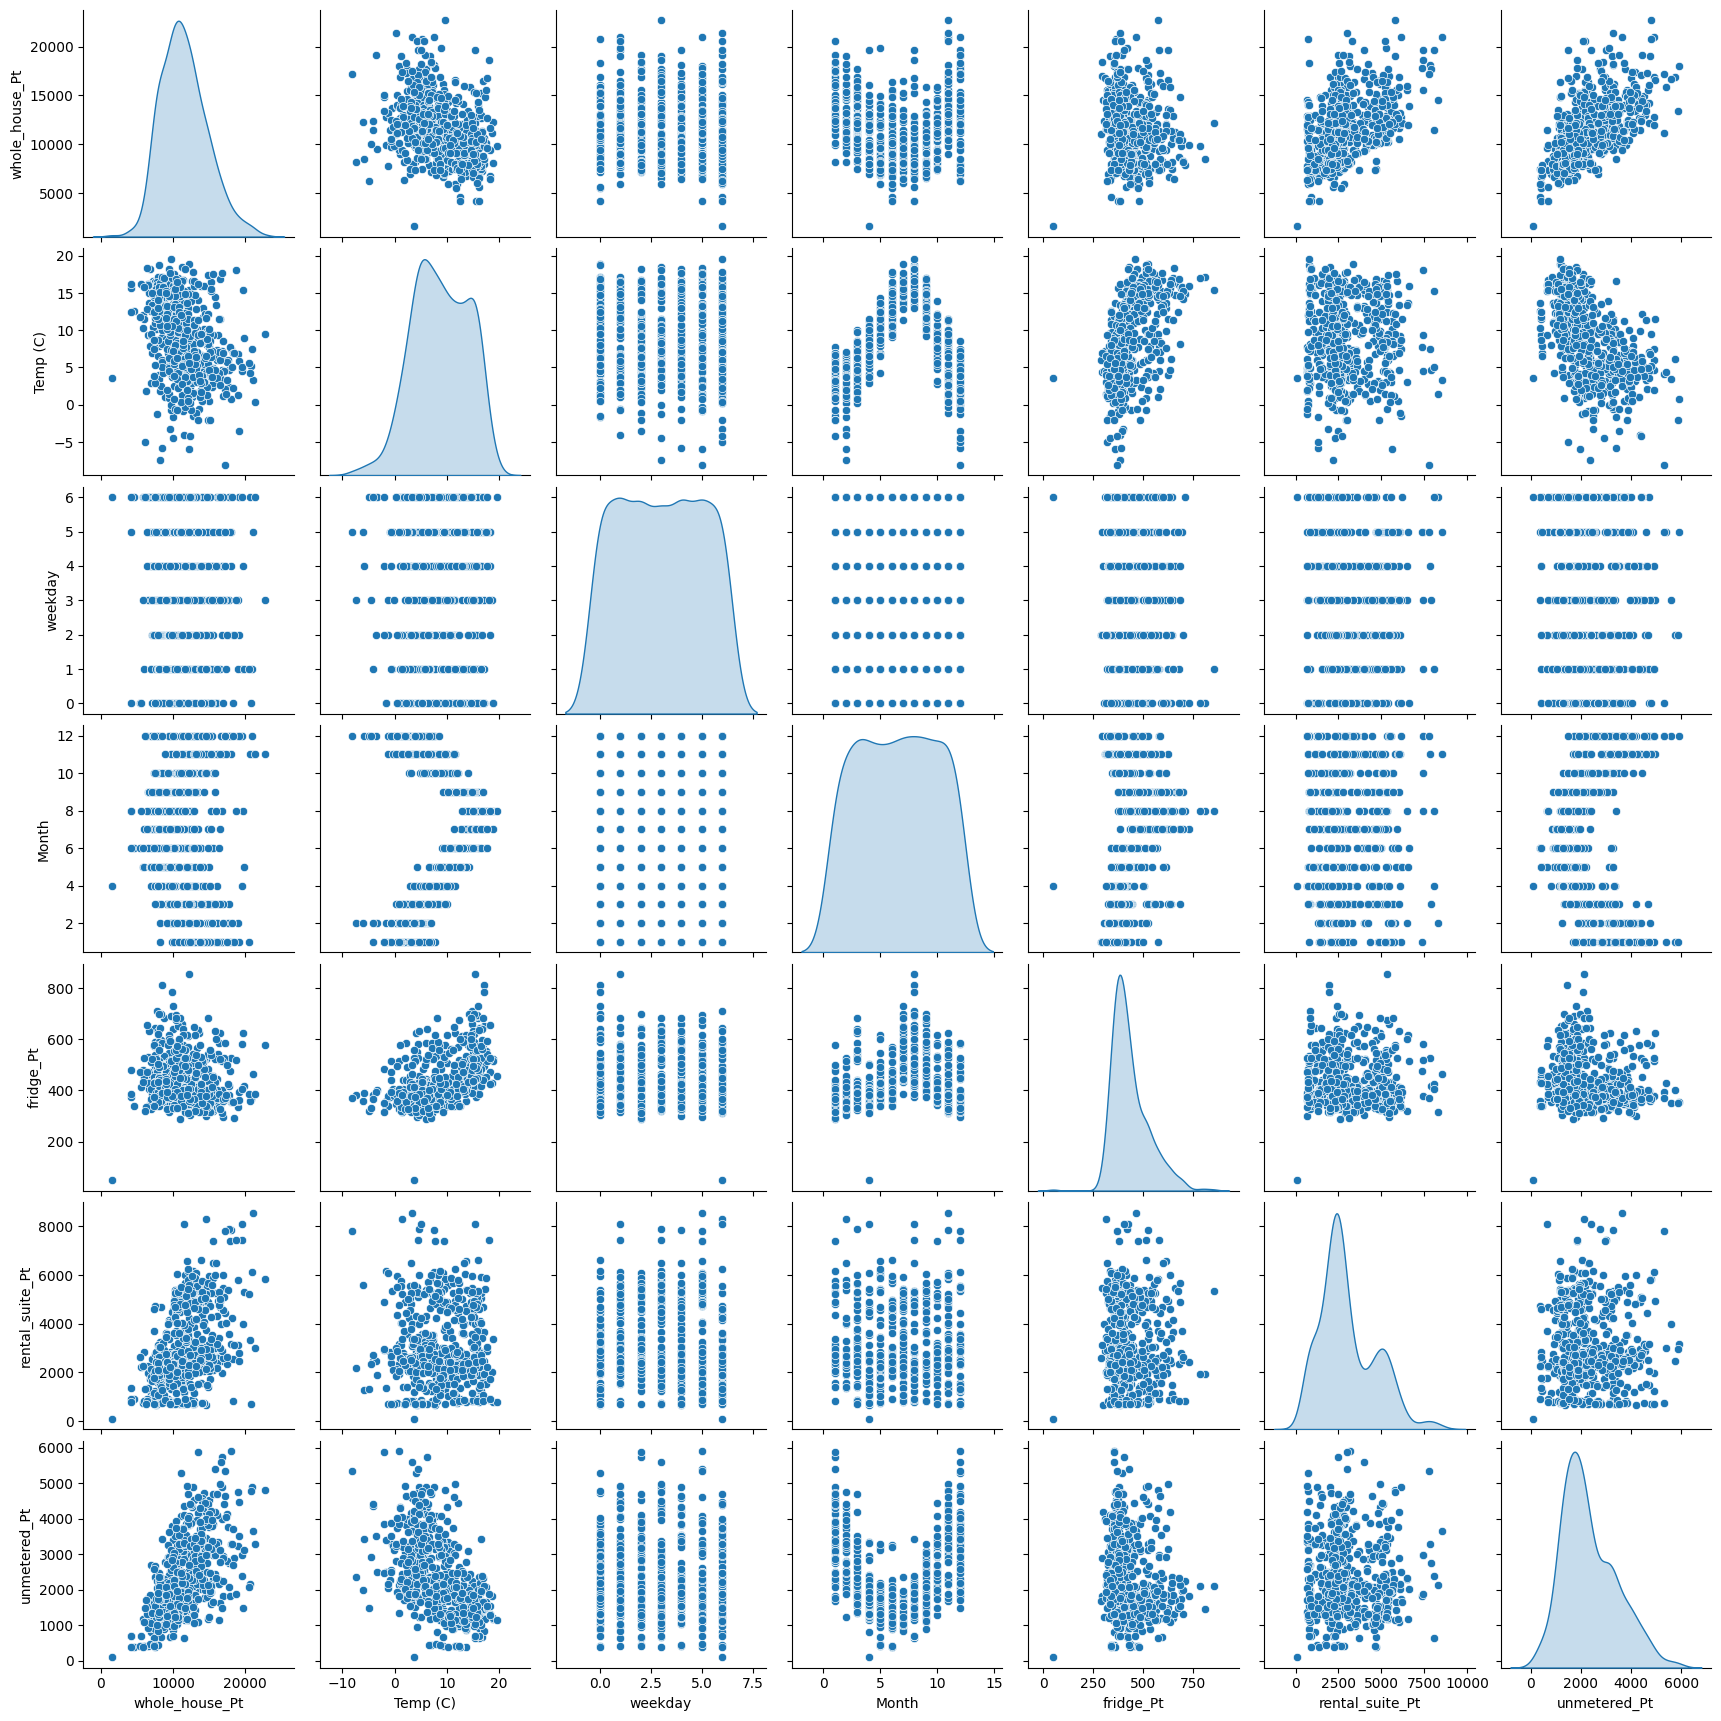

In [15]:
# Split dataset in train and test
# train_dataset = master_day_df.sample(frac=0.8, random_state=0)
# test_dataset = master_day_df.drop(train_dataset.index)

train_dataset = master_night_df.sample(frac=0.8, random_state=0)
test_dataset = master_night_df.drop(train_dataset.index)
# Pairplot of some columns for better ideation
sns.pairplot(train_dataset[['whole_house_Pt', 'Temp (C)', 'weekday', 'Month', 'fridge_Pt', 'rental_suite_Pt', 'unmetered_Pt']], diag_kind='kde')

In [16]:
# Helper function to plot loss during training
def plot_loss(history, name):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1000])
    plt.xlabel('Epoch')
    plt.ylabel(f'Error: {name}')
    plt.legend()
    plt.grid(True)

Here we design a function to build and train (or fit) a linear kernel for our regression model.
It uses Adam optimisation and is trained for 800 epochs

In [17]:
# Linear regression
def fit_linear(train_features, train_labels, name, normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(units=1)
    ])

    model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

    history = model.fit(
        train_features,
        train_labels,
        epochs=1000,
        # Suppress logging.
        verbose=0,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2)

    plot_loss(history, name)
    return model

We then prepare the data, getting fridge energy readings as labels, and according temperature as features, apply tensorflow inbuilt normalization layer and fit the linear model.

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-06-20 11:22:46.962863: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


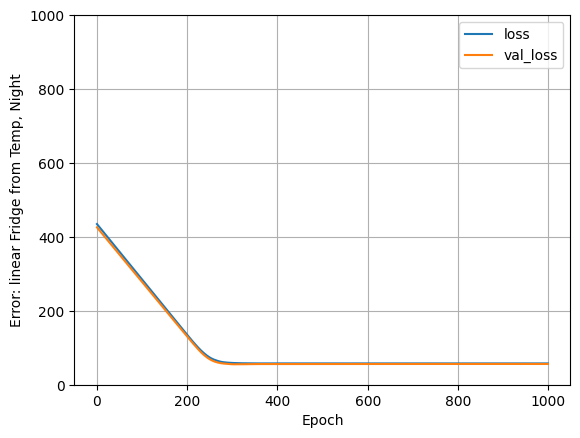

In [18]:
train_dataset = train_dataset.copy() \
                              .dropna()
test_dataset = test_dataset.copy() \
                            .dropna()

train_labels_fridge = train_dataset['fridge_Pt']
test_labels_fridge = test_dataset['fridge_Pt']

train_features = train_dataset['Temp (C)']
test_features = test_dataset['Temp (C)']
# Convert to NP
train_features = np.asarray(train_features)
train_labels = np.asarray(train_labels_fridge)
test_features = np.asarray(test_features)
test_labels = np.asarray(test_labels_fridge)

normalizer = layers.Normalization(input_shape=[1,], axis=None)
normalizer.adapt(train_features)

# Fit the model
linear_fridge_temp_day = fit_linear(train_features=train_features,
                                    train_labels=train_labels_fridge,
                                    name='linear Fridge from Temp, Night',
                                    normalizer=normalizer)

We see that the error stabilizes at around 500 epochs.
We further look at the results and plot the fitted line against the test datapoints.

1/1 [==============================] - 0s 51ms/step
{'linear': 50.423988342285156}


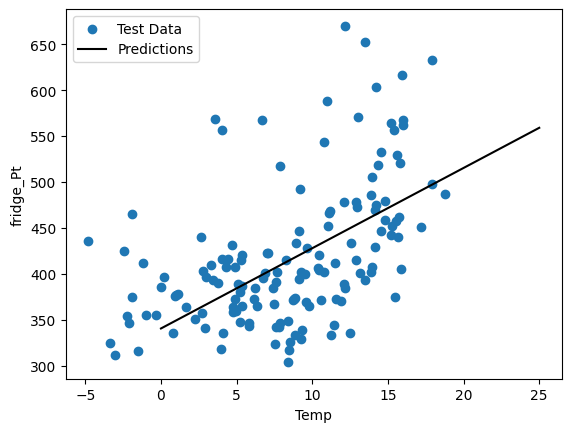

In [19]:
test_results = {}

test_results['linear'] = linear_fridge_temp_day.evaluate(
    test_features,
    test_labels, verbose=0)

x = tf.linspace(0.0, 25, 25)
y = linear_fridge_temp_day.predict(x)

plt.scatter(test_features, test_labels_fridge, label='Test Data')
plt.plot(x, y, color='k', label='Predictions')
plt.xlabel('Temp')
plt.ylabel('fridge_Pt')
plt.legend()

print(test_results)

Now we show how the line was filled to the training data

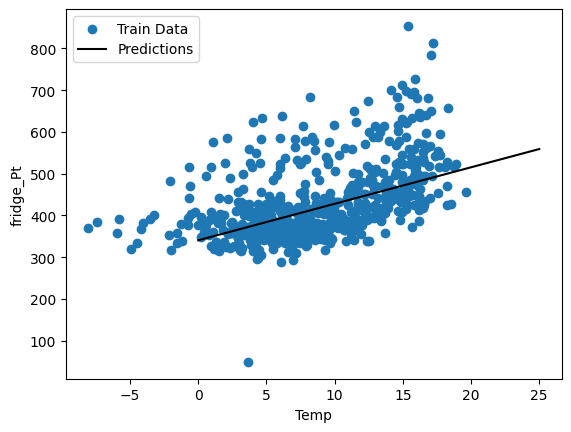

In [20]:
plt.scatter(train_features, train_labels_fridge, label='Train Data')
plt.plot(x, y, color='k', label='Predictions')
plt.xlabel('Temp')
plt.ylabel('fridge_Pt')
plt.legend()

It looks okay, but we feel like we can do better, even for fridge, which is the most linearly related to temperature form all the other appliances.

For this, we employ a DNN regression, where the kernel is a Deep Neural Network.
It can learn a more complex shape than a linear function and is more flexible, which means we can apply it to all the other appliances.

<!-- https://developer.nvidia.com/blog/a-comprehensive-overview-of-regression-evaluation-metrics/?ncid=so-link-677652-vt27&=&linkId=100000199482743#cid=an01_so-link_en-us

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
https://www.tensorflow.org/tutorials/keras/regression#clean_the_data -->

In [21]:
# DNN with 2 hidden layers of size 64
def get_dnn(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
  ])
    # Adam optimiser with learning rate 
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.legacy.Adam(0.003))
  return model

dnn_model = get_dnn(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                128       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,404
Trainable params: 6,401
Non-trainable params: 3
____________________________________________________

We train the DNN and see that it finds the minima pretty quickly (< 10 epochs), with slightly less absolute error (66 kWh vs 70 for linear model)

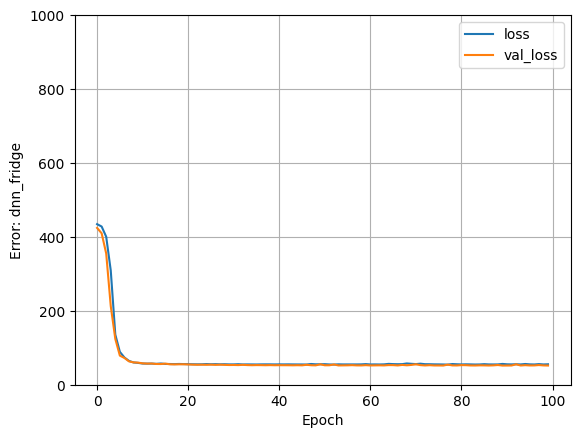

In [22]:
history_dnn = dnn_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history_dnn, 'dnn_fridge')

We also see the difference of the fitted line - it resembles the shape of the relation much better than a linear model

{'linear': 50.423988342285156, 'dnn_fridge': 46.68486022949219}
8/8 [==============================] - 0s 5ms/step


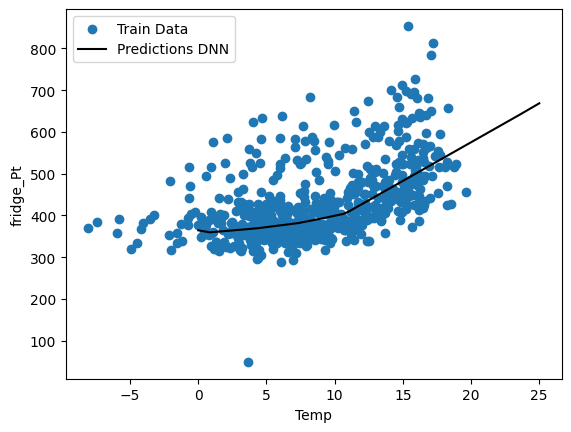

In [23]:
# Add dnn results
test_results['dnn_fridge'] = dnn_model.evaluate(
    test_features, test_labels,
    verbose=0)

print(test_results)

x = tf.linspace(0.0, 25, 251)
y = dnn_model.predict(x)

plt.scatter(train_features, train_labels_fridge, label='Train Data')
plt.plot(x, y, color='k', label='Predictions DNN')
plt.xlabel('Temp')
plt.ylabel('fridge_Pt')
plt.legend()


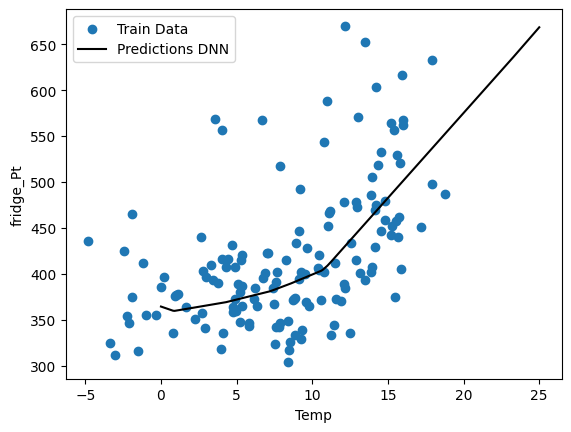

In [41]:
plt.scatter(test_features, test_labels_fridge, label='Train Data')
plt.plot(x, y, color='k', label='Predictions DNN')
plt.xlabel('Temp')
plt.ylabel('fridge_Pt')
plt.legend()

Now we make a DNN regression model for every appliance, and see how they fit the pairings

In [24]:
pt_cols = [col for col in master_day_df.columns if '_Pt' in col]

dnn_models = {}
dnn_models_hist = {}

for col in pt_cols:
    train_labels = train_dataset[col]
    train_labels = np.asarray(train_labels)
    test_labels = test_dataset[col]
    test_labels = np.asarray(test_labels)
    normalizer = layers.Normalization(input_shape=[1,], axis=None)
    normalizer.adapt(train_features)

    dnn_models[col] = get_dnn(normalizer)
    dnn_models_hist[col] = dnn_models[col].fit(
            train_features,
            train_labels,
            epochs=150,
            # Suppress logging.
            verbose=0,
            # Calculate validation results on 20% of the training data.
            validation_split = 0.2)


In [ ]:

x = tf.linspace(0.0, 25, 251)
fig, ax = plt.subplots(11, 2, figsize=(20, 100))
ax = ax.flatten()

for i, col in enumerate(pt_cols):
    pred = dnn_models[col].predict(x).flatten()
    sns.scatterplot(data=train_dataset, x='Temp (C)', y=col, ax=ax[i])
    sns.lineplot(x=x, y=pred, color='r', ax=ax[i])
    ax[i].set_title(f'{col} vs Temperature', fontstyle='italic')
    ax[i].set_title("Day", fontfamily='serif', loc='left', fontsize='medium')

We have now trained 22 separate predictors, of which 21 aggregate together to the whole house energy (including the garage), and one is standalone the whole house energy.

As a next step, we will compare the accuracy of the sum of predictions of 21 predictors versus whole house test labels, as well as the accuracy of the whole house standalone predictor against the same labels.

In [26]:
# We have 146 test temperature readings
from sklearn.metrics import mean_absolute_error

# Predict whole house energy from the standalone model
pred_whole_house = dnn_models['whole_house_Pt'].predict(test_features)

test_labels = test_dataset['whole_house_Pt']
test_labels = np.asarray(test_labels)

ma = mean_absolute_error(test_labels, pred_whole_house)
print(ma)

# Predict whole house energy as sum of predictions of house components
pred_aggregate = 0
for i, col in enumerate(pt_cols):
    if col != 'whole_house_Pt':
        pred = dnn_models[col].predict(test_features)
        pred_aggregate += pred

ma = mean_absolute_error(test_labels, pred_aggregate)
print(ma)


5/5 [==============================] - 0s 17ms/step
2262.6978676155823
5/5 [==============================] - 0s 11ms/step
2599.1938610338184


As a result we get a Mean Absolute Error of **2262.57** for the standalone predictor, and **2599.11** for the aggregate of 21 individual models for house components on a night dataset.

Both of the errors show that the method does not work too well for the given data, perhaps more data preprocessing and cleaning could help make the predictors more accurate.

We repeat the same procedure for the day dataset below, which yields respective Mean Absolute Errors of **2538.42** and  **2772.87**.
The difference between two different aproaches for day data are in sync with the night approach, but a re both relatively higher, which means that the daily data is harder to describe with a regression model.

This is in line with the initial assumption that the energy consumption during the day is more dependant on the activities of inhabitants which are less related to weather.

In [27]:
# Create 22 new models for day data
train_dataset_day = master_day_df.sample(frac=0.8, random_state=0)
test_dataset_day = master_day_df.drop(train_dataset_day.index)

train_dataset_day = train_dataset_day.copy() \
                              .dropna()
test_dataset_day = test_dataset_day.copy() \
                            .dropna()

train_features_day = np.asarray(train_dataset_day['Temp (C)'])

dnn_models_day = {}
dnn_models_day_hist = {}

for col in pt_cols:
    train_labels = np.asarray(train_dataset_day[col])
    test_labels = np.asarray(test_dataset_day[col])
    normalizer = layers.Normalization(input_shape=[1,], axis=None)
    normalizer.adapt(train_features_day)

    dnn_models_day[col] = get_dnn(normalizer)
    dnn_models_day_hist[col] = dnn_models_day[col].fit(
            train_features_day,
            train_labels,
            epochs=150,
            # Suppress logging.
            verbose=0,
            # Calculate validation results on 20% of the training data.
            validation_split = 0.2)


In [ ]:
# Plot the curves of day data against day training data
x = tf.linspace(0.0, 25, 251)
fig, ax = plt.subplots(11, 2, figsize=(20, 100))
ax = ax.flatten()

for i, col in enumerate(pt_cols):
    pred = dnn_models_day[col].predict(x).flatten()
    sns.scatterplot(data=train_dataset_day, x='Temp (C)', y=col, ax=ax[i])
    sns.lineplot(x=x, y=pred, color='r', ax=ax[i])
    ax[i].set_title(f'{col} vs Temperature', fontstyle='italic')
    ax[i].set_title("Day", fontfamily='serif', loc='left', fontsize='medium')

In [29]:
# Predict whole house energy from the standalone model
test_features_day = np.asarray(test_dataset_day['Temp (C)'])
pred_whole_house = dnn_models_day['whole_house_Pt'].predict(test_features_day)

test_labels_day = test_dataset_day['whole_house_Pt']
test_labels_day = np.asarray(test_labels_day)

ma = mean_absolute_error(test_labels_day, pred_whole_house)
print(ma)

# Predict whole house energy as sum of predictions of house components
pred_aggregate = 0
for i, col in enumerate(pt_cols):
    if col != 'whole_house_Pt':
        pred = dnn_models_day[col].predict(test_features_day)
        pred_aggregate += pred

ma = mean_absolute_error(test_labels_day, pred_aggregate)
print(ma)


5/5 [==============================] - 0s 75ms/step
2509.75732421875
5/5 [==============================] - 0s 17ms/step
2791.4127022879466


### Random Forest

Here I apply the random forest approach to the same data to see if it can improve on the performance of the DNN regression

In [30]:
# train_dataset = master_night_df.sample(frac=0.8, random_state=0)
# test_dataset = master_night_df.drop(train_dataset.index)

# Create new DataFrame with only columns 4, 2 and 1
# 'Rel Hum (%)', 'Wind Spd (km/h)', 'Stn Press (kPa)', 'Hmdx']] \
forest_master_df = master_day_df[['Temp (C)','Month', 'Rel Hum (%)', 'Wind Spd (km/h)', 'whole_house_Pt']]

# Split data into training and testing sets
train_df = forest_master_df.sample(frac=0.8, random_state=0)
test_df = forest_master_df.drop(train_df.index)
# train_df.drop(columns=['date'])
train_df

,Temp (C),Month,Rel Hum (%),Wind Spd (km/h),whole_house_Pt
1260,3.63750,12.0,97.8125,9.9375,9518
1296,4.75625,1.0,90.6250,17.8750,19881
950,19.51250,7.0,71.2500,14.6250,14837
174,17.48750,6.0,49.7500,13.3750,11178
872,15.82500,6.0,59.0625,17.7500,12335
...,...,...,...,...,...
976,16.08125,8.0,84.2500,14.1250,9295
52,11.19375,4.0,59.6875,14.4375,14018
224,16.47500,7.0,62.6250,15.3750,10808
306,17.61250,9.0,58.1250,15.3750,10437


In [31]:
# Convert DataFrames into tensorflow datasets
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, task=tfdf.keras.Task.REGRESSION, label='whole_house_Pt')
test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, task=tfdf.keras.Task.REGRESSION, label='whole_house_Pt')

In [32]:
# Define the model
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# Train the model
model.fit(train_data)


Use /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpjpoak6ks as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.122204. Found 558 examples.
Training model...
Model trained in 0:00:00.153905
Compiling model...


[INFO 23-06-20 11:37:50.9529 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpjpoak6ks/model/ with prefix 6888ae8a0ced47fe
[INFO 23-06-20 11:37:51.0256 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52618 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:51.0257 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-06-20 11:37:51.0257 CEST kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [33]:

model.compile(metrics=["mean_absolute_error"])
evaluation = model.evaluate(test_data, return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

results = model.predict(test_data, verbose=0).flatten()
# results

# # Evaluate the model
model.evaluate(test_data)

1/1 [==============================] - 0s 204ms/step - loss: 0.0000e+00 - mean_absolute_error: 2247.4973
loss: 0.0000
mean_absolute_error: 2247.4973
1/1 [==============================] - 0s 85ms/step - loss: 0.0000e+00 - mean_absolute_error: 2247.4973


[0.0, 2247.497314453125]

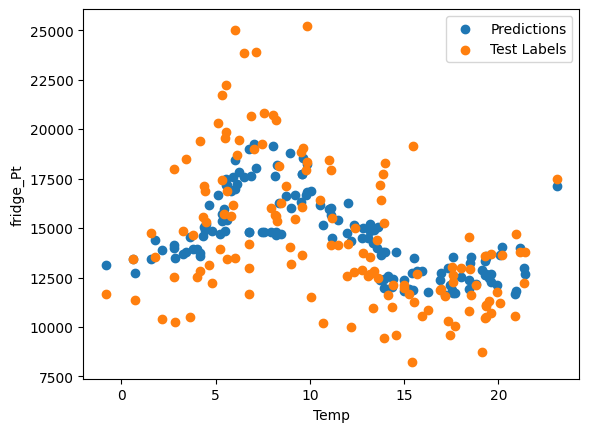

In [34]:
# plt.plot(train_data['Temc (C)'], results, color='k', label='Predictions')

def reject_outliers(data_in, m=2):
    data = data_in.copy()
    data[abs(data - np.mean(data)) > m * np.std(data)] = np.mean(data)
    return data

results_norm = reject_outliers(results)

plt.scatter(test_df['Temp (C)'], results_norm, label='Predictions')
plt.scatter(test_df['Temp (C)'], test_df['whole_house_Pt'], label='Test Labels')
plt.xlabel('Temp')
plt.ylabel('fridge_Pt')
plt.legend()

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
ma = mean_absolute_error(test_df['whole_house_Pt'], results_norm)
rms = mean_squared_error(test_df['whole_house_Pt'], results_norm, squared=False)
print(ma)
print(rms)

2252.711195591518
2897.2214165448113


add cross-validation

In [36]:
def evaluate_forest_for_label(label:str):
    label_master_df = master_day_df[['Temp (C)','Month', 'Rel Hum (%)', 'Wind Spd (km/h)', label]]

    # Split data into training and testing sets
    train_df = label_master_df.sample(frac=0.8, random_state=0)
    test_df = label_master_df.drop(train_df.index)

    train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, task=tfdf.keras.Task.REGRESSION, label=label)
    test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, task=tfdf.keras.Task.REGRESSION, label=label)

    # Define the model
    model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)

    # Train the model
    model.fit(train_data, verbose=0)

    model.compile(metrics=["mean_absolute_error"])
    evaluation = model.evaluate(test_data, return_dict=True)

    for name, value in evaluation.items():
        print(f"{name}: {value:.4f}")

    results = model.predict(test_data, verbose=0).flatten()

    # # Evaluate the model
    # model.evaluate(test_data)

    # ma = mean_absolute_error(test_df[label], results)
    # rms = mean_squared_error(test_df[label], results_norm, squared=False)
    # print(f'MA for {label} = {ma}')
    return results


pt_cols = [col for col in master_day_df.columns if '_Pt' in col]

results_total = 0
for col in pt_cols:
    if col != 'whole_house_Pt':
        results_total += evaluate_forest_for_label(col)


[INFO 23-06-20 11:37:52.3104 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmp3xjsvq4w/model/ with prefix 9801b0f9fd6a48b2


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - mean_absolute_error: 3.8490

[INFO 23-06-20 11:37:52.3545 CEST decision_forest.cc:660] Model loaded with 300 root(s), 35620 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:52.3545 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 97ms/step - loss: 0.0000e+00 - mean_absolute_error: 3.8490
loss: 0.0000
mean_absolute_error: 3.8490


[INFO 23-06-20 11:37:52.6971 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpjm62yrkl/model/ with prefix 8ea1251bca1d4203


[INFO 23-06-20 11:37:52.7613 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52160 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:52.7613 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 71ms/step - loss: 0.0000e+00 - mean_absolute_error: 164.9542
loss: 0.0000
mean_absolute_error: 164.9542


[INFO 23-06-20 11:37:53.0892 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpbm35db63/model/ with prefix 65edaf5d1f474fb7
[INFO 23-06-20 11:37:53.1538 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52510 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:53.1538 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 93ms/step - loss: 0.0000e+00 - mean_absolute_error: 276.7917
loss: 0.0000
mean_absolute_error: 276.7917


[INFO 23-06-20 11:37:53.4939 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpsszgbe9d/model/ with prefix 982cf9b659804e5d
[INFO 23-06-20 11:37:53.5394 CEST decision_forest.cc:660] Model loaded with 300 root(s), 37218 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:53.5395 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 94ms/step - loss: 0.0000e+00 - mean_absolute_error: 941.0808
loss: 0.0000
mean_absolute_error: 941.0808


[INFO 23-06-20 11:37:53.8750 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmp3__tji9s/model/ with prefix f53858ed92854021
[INFO 23-06-20 11:37:53.9245 CEST decision_forest.cc:660] Model loaded with 300 root(s), 40204 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:53.9245 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 70ms/step - loss: 0.0000e+00 - mean_absolute_error: 103.3592
loss: 0.0000
mean_absolute_error: 103.3592


[INFO 23-06-20 11:37:54.2420 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpgk_qx5d7/model/ with prefix 42d0e8d12ea84338
[INFO 23-06-20 11:37:54.2966 CEST decision_forest.cc:660] Model loaded with 300 root(s), 44258 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:54.2966 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 96ms/step - loss: 0.0000e+00 - mean_absolute_error: 15.4960
loss: 0.0000
mean_absolute_error: 15.4960


[INFO 23-06-20 11:37:54.6303 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmp77b0gb4t/model/ with prefix dabdee0d1f524a04
[INFO 23-06-20 11:37:54.6655 CEST decision_forest.cc:660] Model loaded with 300 root(s), 28836 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:54.6655 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 97ms/step - loss: 0.0000e+00 - mean_absolute_error: 250.4146
loss: 0.0000
mean_absolute_error: 250.4146


[INFO 23-06-20 11:37:55.3503 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpeqtghmlp/model/ with prefix fbdeb59928db4f25
[INFO 23-06-20 11:37:55.4035 CEST decision_forest.cc:660] Model loaded with 300 root(s), 43722 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:55.4036 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 97ms/step - loss: 0.0000e+00 - mean_absolute_error: 186.8848
loss: 0.0000
mean_absolute_error: 186.8848


[INFO 23-06-20 11:37:55.7499 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpqlj4tdrr/model/ with prefix ed2514902aaa4d07


1/1 [==============================] - 0s 68ms/step - loss: 0.0000e+00 - mean_absolute_error: 11.1300


[INFO 23-06-20 11:37:55.8141 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52084 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:55.8141 CEST kernel.cc:1074] Use fast generic engine


loss: 0.0000
mean_absolute_error: 11.1300


[INFO 23-06-20 11:37:56.1373 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmp1l1lj00h/model/ with prefix f112afa492004b98
[INFO 23-06-20 11:37:56.2058 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52508 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:56.2059 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 121ms/step - loss: 0.0000e+00 - mean_absolute_error: 71.2330
loss: 0.0000
mean_absolute_error: 71.2330


[INFO 23-06-20 11:37:56.6170 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpblusrvbp/model/ with prefix 0c7214b484f242ff
[INFO 23-06-20 11:37:56.6833 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52848 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:56.6834 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 109ms/step - loss: 0.0000e+00 - mean_absolute_error: 104.4721
loss: 0.0000
mean_absolute_error: 104.4721


[INFO 23-06-20 11:37:57.0606 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmph1tu8ue4/model/ with prefix 567ca4c7532c4de3
[INFO 23-06-20 11:37:57.1258 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52244 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:57.1258 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 76ms/step - loss: 0.0000e+00 - mean_absolute_error: 6.6213
loss: 0.0000
mean_absolute_error: 6.6213


[INFO 23-06-20 11:37:57.4615 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmp12r1itmi/model/ with prefix 9057fa9332d748e0
[INFO 23-06-20 11:37:57.5268 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52538 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:57.5268 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 90ms/step - loss: 0.0000e+00 - mean_absolute_error: 1128.8065
loss: 0.0000
mean_absolute_error: 1128.8065


[INFO 23-06-20 11:37:57.8738 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpy4wqu_ta/model/ with prefix 63769a9dad054274
[INFO 23-06-20 11:37:57.9368 CEST decision_forest.cc:660] Model loaded with 300 root(s), 51408 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:57.9369 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 98ms/step - loss: 0.0000e+00 - mean_absolute_error: 11.2952
loss: 0.0000
mean_absolute_error: 11.2952


[INFO 23-06-20 11:37:58.2850 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpsks3l738/model/ with prefix 82638b512c76407e
[INFO 23-06-20 11:37:58.3509 CEST decision_forest.cc:660] Model loaded with 300 root(s), 51544 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:58.3510 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 125ms/step - loss: 0.0000e+00 - mean_absolute_error: 171.3084
loss: 0.0000
mean_absolute_error: 171.3084


[INFO 23-06-20 11:37:58.7513 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpthy12999/model/ with prefix 501f82322c984807
[INFO 23-06-20 11:37:58.8138 CEST decision_forest.cc:660] Model loaded with 300 root(s), 50244 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:58.8138 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 98ms/step - loss: 0.0000e+00 - mean_absolute_error: 1.1815
loss: 0.0000
mean_absolute_error: 1.1815


[INFO 23-06-20 11:37:59.1726 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpx15w6h8x/model/ with prefix 66146bb97b9b4a6b
[INFO 23-06-20 11:37:59.2428 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52610 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:59.2429 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 74ms/step - loss: 0.0000e+00 - mean_absolute_error: 117.7337
loss: 0.0000
mean_absolute_error: 117.7337


[INFO 23-06-20 11:37:59.5647 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpt6xiyptt/model/ with prefix cbb1bdccdbe5450f
[INFO 23-06-20 11:37:59.6315 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52614 node(s), and 4 input feature(s).
[INFO 23-06-20 11:37:59.6315 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 107ms/step - loss: 0.0000e+00 - mean_absolute_error: 79.7329
loss: 0.0000
mean_absolute_error: 79.7329


[INFO 23-06-20 11:38:00.0122 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpd9g572dx/model/ with prefix 5b4c609ed5a04c26
[INFO 23-06-20 11:38:00.0560 CEST decision_forest.cc:660] Model loaded with 300 root(s), 35598 node(s), and 4 input feature(s).
[INFO 23-06-20 11:38:00.0560 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 103ms/step - loss: 0.0000e+00 - mean_absolute_error: 84.5924
loss: 0.0000
mean_absolute_error: 84.5924


[INFO 23-06-20 11:38:00.4174 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmpn_zyw78o/model/ with prefix 174539b6d2234c68
[INFO 23-06-20 11:38:00.4807 CEST decision_forest.cc:660] Model loaded with 300 root(s), 51140 node(s), and 4 input feature(s).
[INFO 23-06-20 11:38:00.4807 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 102ms/step - loss: 0.0000e+00 - mean_absolute_error: 1043.5773
loss: 0.0000
mean_absolute_error: 1043.5773


[INFO 23-06-20 11:38:00.8641 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmp0yevejw0/model/ with prefix 0f286bdb2f3047e7
[INFO 23-06-20 11:38:00.9310 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52754 node(s), and 4 input feature(s).
[INFO 23-06-20 11:38:00.9310 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 104ms/step - loss: 0.0000e+00 - mean_absolute_error: 513.1665
loss: 0.0000
mean_absolute_error: 513.1665


In [37]:

# Split data into training and testing sets
train_df = master_day_df['whole_house_Pt'].sample(frac=0.8, random_state=0)
test_df = master_day_df['whole_house_Pt'].drop(train_df.index)

ma = mean_absolute_error(test_df, results_total)

print(f'Total MA = {ma}')


Total MA = 2257.9454380580355


In [38]:
# Create new DataFrame with only columns 4, 2 and 1
# 'Rel Hum (%)', 'Wind Spd (km/h)', 'Stn Press (kPa)', 'Hmdx']] \
forest_outside_master_df = master_day_df[['Temp (C)','Month', 'Rel Hum (%)', 'Wind Spd (km/h)', 'fridge_Pt']]

# Split data into training and testing sets
train_df_outside = forest_outside_master_df.sample(frac=0.8, random_state=0)
test_df_outside = forest_outside_master_df.drop(train_df_outside.index)
# train_df.drop(columns=['date'])
train_df_outside

,Temp (C),Month,Rel Hum (%),Wind Spd (km/h),fridge_Pt
1260,3.63750,12.0,97.8125,9.9375,626
1296,4.75625,1.0,90.6250,17.8750,651
950,19.51250,7.0,71.2500,14.6250,868
174,17.48750,6.0,49.7500,13.3750,1006
872,15.82500,6.0,59.0625,17.7500,761
...,...,...,...,...,...
976,16.08125,8.0,84.2500,14.1250,787
52,11.19375,4.0,59.6875,14.4375,870
224,16.47500,7.0,62.6250,15.3750,873
306,17.61250,9.0,58.1250,15.3750,787


In [39]:
# Convert DataFrames into tensorflow datasets
train_data_outside = tfdf.keras.pd_dataframe_to_tf_dataset(train_df_outside, task=tfdf.keras.Task.REGRESSION, label='fridge_Pt')
test_data_outside = tfdf.keras.pd_dataframe_to_tf_dataset(test_df_outside, task=tfdf.keras.Task.REGRESSION, label='fridge_Pt')

# Define the model
model_outside = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# Train the model
model_outside.fit(train_data_outside)

model_outside.compile(metrics=["mean_absolute_error"])
evaluation = model_outside.evaluate(test_data_outside, return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

results_outside = model_outside.predict(test_data_outside, verbose=0).flatten()
# results

# # Evaluate the model
model_outside.evaluate(test_data_outside)

Use /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmp61dmk8mb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095379. Found 558 examples.
Training model...


[INFO 23-06-20 11:38:01.3274 CEST kernel.cc:1242] Loading model from path /var/folders/46/mv3h70tx39v9hjm5nbgf6_5w0000gn/T/tmp61dmk8mb/model/ with prefix 2f671b08d83148a3


Model trained in 0:00:00.130904
Compiling model...
Model compiled.


[INFO 23-06-20 11:38:01.3919 CEST decision_forest.cc:660] Model loaded with 300 root(s), 52508 node(s), and 4 input feature(s).
[INFO 23-06-20 11:38:01.3919 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-06-20 11:38:01.3920 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 98ms/step - loss: 0.0000e+00 - mean_absolute_error: 71.2330
loss: 0.0000
mean_absolute_error: 71.2330
1/1 [==============================] - 0s 78ms/step - loss: 0.0000e+00 - mean_absolute_error: 71.2330


[0.0, 71.23298645019531]

72.84453517368861
91.08915975879529


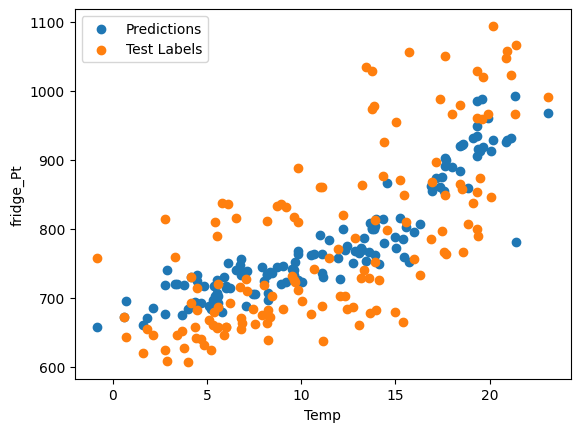

In [40]:
def reject_outliers(data_in, m=2.5):
    data = data_in.copy()
    data[abs(data - np.mean(data)) > m * np.std(data)] = np.mean(data)
    return data

results_norm_outside = reject_outliers(results_outside)

plt.scatter(test_df_outside['Temp (C)'], results_norm_outside, label='Predictions')
plt.scatter(test_df_outside['Temp (C)'], test_df_outside['fridge_Pt'], label='Test Labels')
plt.xlabel('Temp')
plt.ylabel('fridge_Pt')
plt.legend()

from sklearn.metrics import mean_absolute_error, mean_squared_error
ma = mean_absolute_error(test_df_outside['fridge_Pt'], results_norm_outside)
rms = mean_squared_error(test_df_outside['fridge_Pt'], results_norm_outside, squared=False)
print(ma)
print(rms)